# HDF5 files' ECG content

In [1]:
# Get list of ECG files in mounted disk
import h5py
import glob
import matplotlib.pyplot as plt
ecg_files = glob.glob('/mnt/disks/ecg-rest-31k/2019-06-10/*.hd5')

Normal sinus rhythm
median_I 600
median_II 600
median_III 600
median_V1 600
median_V2 600
median_V3 600
median_V4 600
median_V5 600
median_V6 600
median_aVF 600
median_aVL 600
median_aVR 600
strip_I 5000
strip_II 5000
strip_III 5000
strip_V1 5000
strip_V2 5000
strip_V3 5000
strip_V4 5000
strip_V5 5000
strip_V6 5000
strip_aVF 5000
strip_aVL 5000
strip_aVR 5000


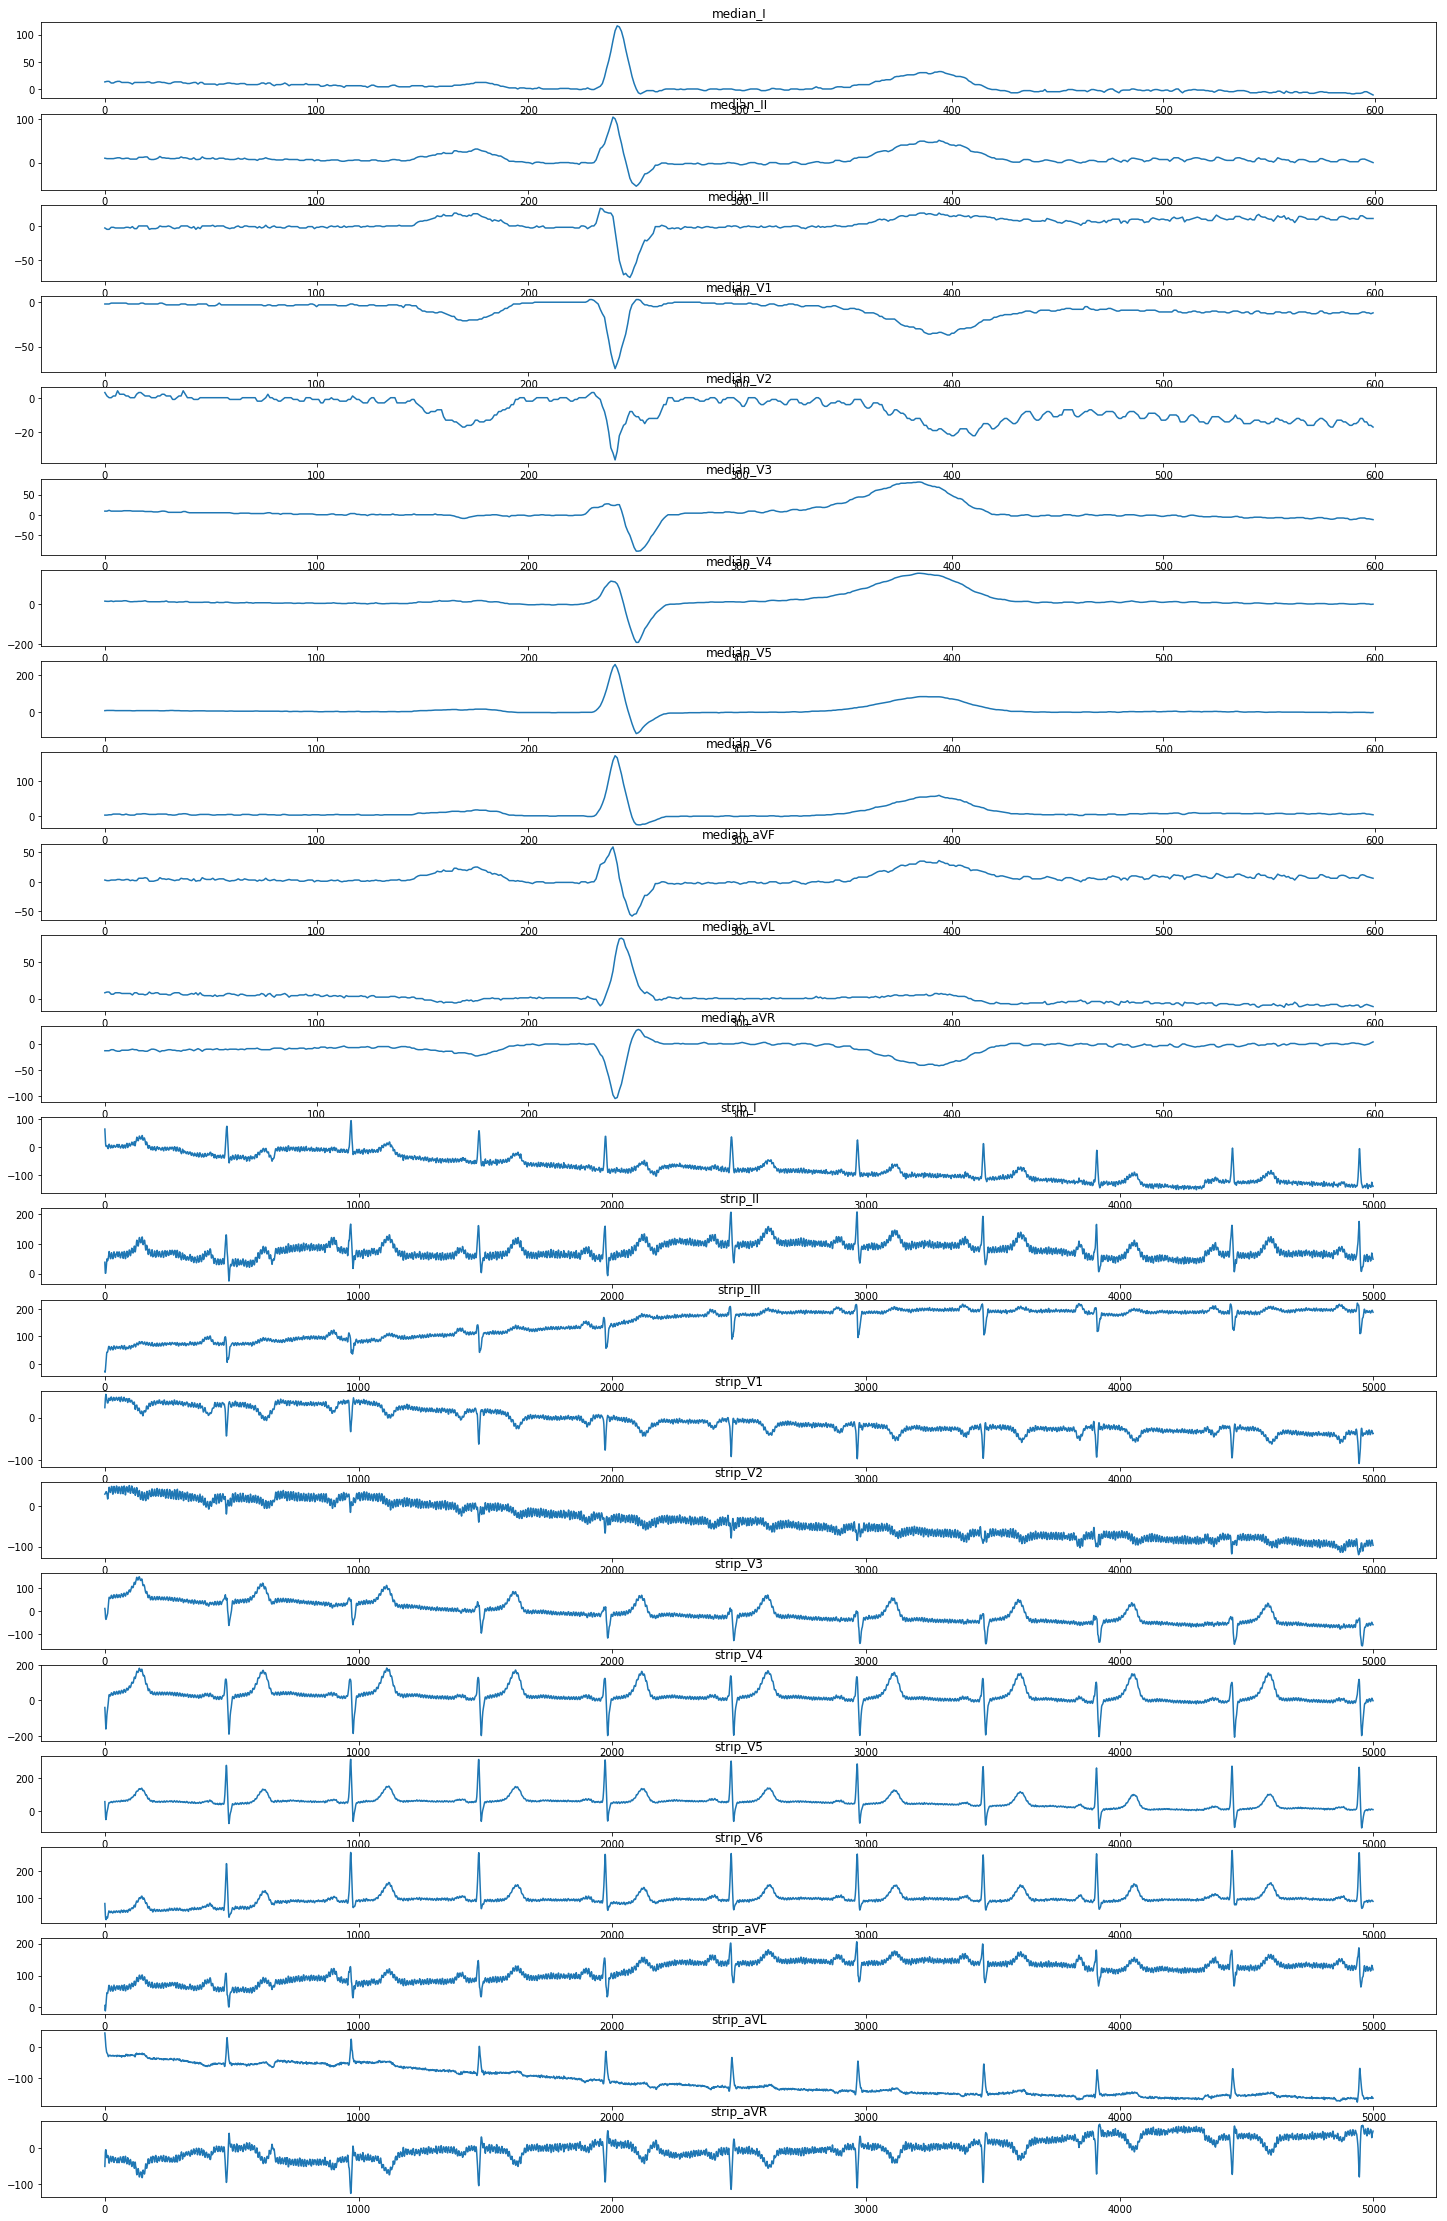

In [2]:
# Plot ecg_rest contents of a typical datafile
ff = h5py.File(ecg_files[0], 'r')
f, ax = plt.subplots(len(ff['/ecg_rest'].keys()), 1)
f.set_size_inches(25, 40)
print(ff['/ecg_rest_text'][0])
for i, ff_k in enumerate(ff['/ecg_rest'].keys()):    
    ax[i].plot(list(ff['/ecg_rest/' + ff_k]))
    ax[i].set_title(ff_k)
    print(ff_k, len(list(ff['/ecg_rest/' + ff_k])))
ff.close()

# Classifier of ECG Rhythm

In [21]:
import os
import sys
import numpy as np
from keras.models import load_model
#Imports from ml4cvd
from ml4cvd.arguments import parse_args
from ml4cvd.tensor_generators import test_train_valid_tensor_generators, big_batch_from_minibatch_generator
from ml4cvd.models import make_multimodal_multitask_model, train_model_from_generators
from ml4cvd.recipes import plot_predictions, _predict_and_evaluate, evaluate_predictions
from ml4cvd.metrics import get_metric_dict

In [22]:
# Train an ECG Rhythm classifier
sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-rest-31k/2019-06-10/',
            '--input_tensors', 'ecg_rest', 
            '--output_tensors','ecg_semi_coarse',
            '--batch_size', '32', 
            '--epochs', '64',
            '--training_steps', '96',
            '--validation_steps', '32',
            '--test_steps', '24',
            '--patience', '12',
            '--inspect_model',
            '--u_connect',
            '--learning_rate', '0.00002',
            '--id', 'ecg_pd_rhythm_classifier',
            '--output_folder', '/home/pdiachil/ml/notebooks/ecg_rest/trained_models/ecg_compare_baseline/'
           ]
args = parse_args()
generate_train, generate_valid, generate_test = \
    test_train_valid_tensor_generators(args.tensor_maps_in,
                                       args.tensor_maps_out,
                                       args.tensors, 
                                       args.batch_size, 
                                       args.valid_ratio, 
                                       args.test_ratio, 
                                       args.test_modulo, 
                                       args.balance_csvs)

2019-10-11 14:07:04,263 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at /home/pdiachil/ml/notebooks/ecg_rest/trained_models/ecg_compare_baseline/ecg_pd_rhythm_classifier/log_2019-10-11_14-07_0.log.
2019-10-11 14:07:04,265 - arguments:199 - INFO - Command Line was:

./scripts/tf.sh train --tensors /mnt/disks/ecg-rest-31k/2019-06-10/ --input_tensors ecg_rest --output_tensors ecg_semi_coarse --batch_size 32 --epochs 64 --training_steps 96 --validation_steps 32 --test_steps 24 --patience 12 --inspect_model --u_connect --learning_rate 0.00002 --id ecg_pd_rhythm_classifier --output_folder /home/pdiachil/ml/notebooks/ecg_rest/trained_models/ecg_compare_baseline/



2019-10-11 14:07:04,266 - arguments:200 - INFO - Total TensorMaps:255 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-crede

In [5]:
model = make_multimodal_multitask_model(**args.__dict__)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_strip_ecg_rest (InputLaye (None, 5000, 12)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5000, 32)     27296       input_strip_ecg_rest[0][0]       
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 5000, 32)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 5000, 32)     72736       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [ ]:
###### TRAINING ######
model = train_model_from_generators(model, generate_train, generate_valid, 
                                    args.training_steps, args.validation_steps,                                     
                                    args.batch_size, args.epochs, args.patience,
                                    args.output_folder, args.id, args.inspect_model, 
                                    args.inspect_show_labels)
######################

In [58]:
# Evaluate prediction from model trained by me
model = load_model(os.path.join(args.output_folder, args.id, args.id+'.hd5'), 
                   custom_objects=get_metric_dict(args.tensor_maps_out))
out_path = os.path.join(args.output_folder, args.id+'/')
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, 
                                                                        args.tensor_maps_out, 
                                                                        generate_test, 
                                                                        args.test_steps)
performance_metrics = _predict_and_evaluate(model, test_data, test_labels, 
                                            args.tensor_maps_in, args.tensor_maps_out, 
                                            args.batch_size, args.hidden_layer, 
                                            out_path, test_paths, args.alpha)

plt.imshow(os.path.join(args.output_folder, args.id, 'metric_history'+args.id+'.png'))
performance_metrics
           

2019-10-11 14:51:02,681 - tensor_generators:248 - INFO - Input tensor 'input_strip_ecg_rest' has shape (768, 5000, 12)
2019-10-11 14:51:02,684 - tensor_generators:251 - INFO - Output tensor 'output_ecg_semi_coarse_categorical' has shape (768, 6)
2019-10-11 14:51:08,426 - plots:62 - INFO - For tm:ecg_semi_coarse with channel map:{'Normal_sinus_rhythm': 0, 'Sinus_bradycardia': 1, 'Marked_sinus_bradycardia': 2, 'Other_sinus_rhythm': 3, 'Atrial_fibrillation': 4, 'Other_rhythm': 5} examples:768
2019-10-11 14:51:08,429 - plots:63 - INFO - 
Sum Truth:[359. 275.  82.  33.  12.   7.] 
Sum pred :[221.98483  228.54544   80.982704 120.77124   65.78895   49.927017]
2019-10-11 14:51:08,452 - plots:723 - INFO - prAUC Label Normal_sinus_rhythm mean precision:0.936 n=359
2019-10-11 14:51:08,458 - plots:723 - INFO - prAUC Label Sinus_bradycardia mean precision:0.990 n=275
2019-10-11 14:51:08,463 - plots:723 - INFO - prAUC Label Marked_sinus_bradycardia mean precision:0.993 n=82
2019-10-11 14:51:08,468 -

{'Normal_sinus_rhythm': 0.9678882524807432,
 'Sinus_bradycardia': 0.9945270145675825,
 'Marked_sinus_bradycardia': 0.9990933655692242,
 'Other_sinus_rhythm': 0.7250051535765821,
 'Atrial_fibrillation': 0.9351851851851851,
 'Other_rhythm': 0.7816782429134597}

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 2304x2304 with 0 Axes>

2019-10-11 15:04:35,618 - tensor_generators:248 - INFO - Input tensor 'input_strip_ecg_rest' has shape (768, 5000, 12)
2019-10-11 15:04:35,621 - tensor_generators:251 - INFO - Output tensor 'output_ecg_semi_coarse_categorical' has shape (768, 6)


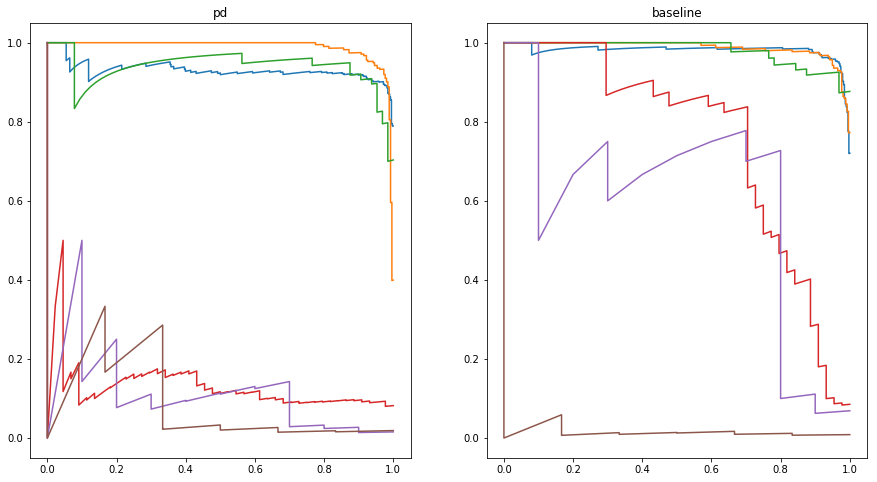

In [64]:
# Evaluate prediction from model trained by team
model_baseline = load_model('/mnt/ml4cvd/projects/jamesp/data/models/ecg_rest_semi_coarse_only.hd5', 
                            custom_objects=get_metric_dict(args.tensor_maps_out))
out_path = os.path.join(args.output_folder, args.id+'/')

test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, 
                                                                        args.tensor_maps_out, 
                                                                        generate_test, 
                                                                        args.test_steps)

layer_names = [layer.name for layer in model_baseline.layers]
y_predictions = model.predict(test_data, batch_size=args.batch_size)
y_predictions_baseline = model_baseline.predict(test_data, batch_size=args.batch_size)
f, ax = plt.subplots(1, 2)
f.set_size_inches(15, 8)
ax[0].set_title('pd')
ax[1].set_title('baseline')
for y, tm in zip(y_predictions, args.tensor_maps_out):
    if tm.output_name() not in layer_names:
        continue
    if not isinstance(y_predictions, list):
        y = y_predictions
    y_truth = np.array(test_labels[tm.output_name()])
    for k in tm.channel_map:
        precision, recall, _ = precision_recall_curve(y_truth[:, tm.channel_map[k]],
                                                      y_predictions[:, tm.channel_map[k]])
        ax[0].plot(recall, precision, label=k)
        
        precision, recall, _ = precision_recall_curve(y_truth[:, tm.channel_map[k]],
                                                      y_predictions_baseline[:, tm.channel_map[k]])
        ax[1].plot(recall, precision, label=k)

In [ ]:
# Baseline is much better --> Train more
model = load_model(os.path.join(args.output_folder, 'ecg_pd_rhythm_classifier', args.id+'.hd5'), 
                   custom_objects=get_metric_dict(args.tensor_maps_out))
args.id = 'ecg_pd_rhythm_classifier_more_training'

generate_train, generate_valid, generate_test = \
    test_train_valid_tensor_generators(args.tensor_maps_in,
                                       args.tensor_maps_out,
                                       args.tensors, 
                                       args.batch_size, 
                                       args.valid_ratio, 
                                       args.test_ratio, 
                                       args.test_modulo, 
                                       args.balance_csvs)

model = train_model_from_generators(model, generate_train, generate_valid, 
                                    args.training_steps, args.validation_steps,                                     
                                    args.batch_size, args.epochs, args.patience,
                                    args.output_folder, args.id, args.inspect_model, 
                                    args.inspect_show_labels)

2019-10-11 15:12:07,058 - tensor_generators:292 - INFO - Found 19229 training, 2691 validation, and 8586 testing tensors at: /mnt/disks/ecg-rest-31k/2019-06-10/
2019-10-11 15:12:07,403 - models:789 - INFO - Saving architecture diagram to:/home/pdiachil/ml/notebooks/ecg_rest/trained_models/ecg_compare_baseline/ecg_pd_rhythm_classifier_more_training/architecture_graph_ecg_pd_rhythm_classifier_more_training.png
Epoch 1/1
2019-10-11 15:12:10,198 - tensor_generators:392 - INFO - At tensor path: /mnt/disks/ecg-rest-31k/2019-06-10/2988588.hd5
2019-10-11 15:12:10,227 - tensor_generators:393 - INFO - Got first error: ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 89, in multimodal_multitask_generator
    out_batch[tm.output_name()][stats['batch_index']] = tm.tensor_from_file(tm, hd5)
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/TensorMap.py", line 661, in _default_tenso


Epoch 00002: val_loss did not improve from 1.50016
Epoch 3/64
96/96 [==============================] - 61s 634ms/step - loss: 1.8780 - categorical_accuracy: 0.8389 - Normal_sinus_rhythm_precision: 0.9134 - Sinus_bradycardia_precision: 0.9675 - Marked_sinus_bradycardia_precision: 0.8527 - Other_sinus_rhythm_precision: 0.0000e+00 - Atrial_fibrillation_precision: 0.0885 - Other_rhythm_precision: 0.0104 - Normal_sinus_rhythm_recall: 0.6948 - Sinus_bradycardia_recall: 0.7663 - Marked_sinus_bradycardia_recall: 0.8301 - Other_sinus_rhythm_recall: 0.0000e+00 - Atrial_fibrillation_recall: 0.0712 - Other_rhythm_recall: 0.0104 - val_loss: 2.1384 - val_categorical_accuracy: 0.8398 - val_Normal_sinus_rhythm_precision: 0.8929 - val_Sinus_bradycardia_precision: 0.9910 - val_Marked_sinus_bradycardia_precision: 0.8685 - val_Other_sinus_rhythm_precision: 0.0312 - val_Atrial_fibrillation_precision: 0.0000e+00 - val_Other_rhythm_precision: 0.0000e+00 - val_Normal_sinus_rhythm_recall: 0.6533 - val_Sinus_b

Epoch 7/64
95/96 [============================>.] - ETA: 0s - loss: 1.5602 - categorical_accuracy: 0.8368 - Normal_sinus_rhythm_precision: 0.9063 - Sinus_bradycardia_precision: 0.9678 - Marked_sinus_bradycardia_precision: 0.8809 - Other_sinus_rhythm_precision: 0.0526 - Atrial_fibrillation_precision: 0.1193 - Other_rhythm_precision: 0.0000e+00 - Normal_sinus_rhythm_recall: 0.7511 - Sinus_bradycardia_recall: 0.8004 - Marked_sinus_bradycardia_recall: 0.8857 - Other_sinus_rhythm_recall: 0.0281 - Atrial_fibrillation_recall: 0.1053 - Other_rhythm_recall: 0.0000e+002019-10-11 15:21:34,925 - tensor_generators:121 - INFO - batch_index: 4
2019-10-11 15:21:34,927 - tensor_generators:121 - INFO - Tensors presented: 10372
2019-10-11 15:21:34,929 - tensor_generators:121 - INFO - ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 89, in multimodal_multitask_generator
    out_batch[tm.outp

95/96 [============================>.] - ETA: 0s - loss: 1.6355 - categorical_accuracy: 0.8313 - Normal_sinus_rhythm_precision: 0.9141 - Sinus_bradycardia_precision: 0.9654 - Marked_sinus_bradycardia_precision: 0.8430 - Other_sinus_rhythm_precision: 0.0772 - Atrial_fibrillation_precision: 0.0561 - Other_rhythm_precision: 0.0105 - Normal_sinus_rhythm_recall: 0.6826 - Sinus_bradycardia_recall: 0.8015 - Marked_sinus_bradycardia_recall: 0.8037 - Other_sinus_rhythm_recall: 0.0474 - Atrial_fibrillation_recall: 0.0684 - Other_rhythm_recall: 0.01052019-10-11 15:24:31,410 - tensor_generators:121 - INFO - batch_index: 28
2019-10-11 15:24:31,412 - tensor_generators:121 - INFO - Tensors presented: 37116
2019-10-11 15:24:31,414 - tensor_generators:121 - INFO - ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 89, in multimodal_multitask_generator
    out_batch[tm.output_name()][stats['

20/96 [=====>........................] - ETA: 26s - loss: 1.2100 - categorical_accuracy: 0.8844 - Normal_sinus_rhythm_precision: 0.9450 - Sinus_bradycardia_precision: 0.9895 - Marked_sinus_bradycardia_precision: 0.8587 - Other_sinus_rhythm_precision: 0.2500 - Atrial_fibrillation_precision: 0.0667 - Other_rhythm_precision: 0.0500 - Normal_sinus_rhythm_recall: 0.7826 - Sinus_bradycardia_recall: 0.7950 - Marked_sinus_bradycardia_recall: 0.8825 - Other_sinus_rhythm_recall: 0.1250 - Atrial_fibrillation_recall: 0.1000 - Other_rhythm_recall: 0.0500    2019-10-11 15:27:02,781 - tensor_generators:121 - INFO - batch_index: 7
2019-10-11 15:27:02,783 - tensor_generators:121 - INFO - Tensors presented: 18151
2019-10-11 15:27:02,795 - tensor_generators:121 - INFO - ValueError while attempting to generate tensor:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ml4cvd/tensor_generators.py", line 89, in multimodal_multitask_generator
    out_batch[tm.output_name()][sta

In [ ]:
args.epoch